In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

from src.features.build_features import series_to_supervised

import pickle

Using TensorFlow backend.
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


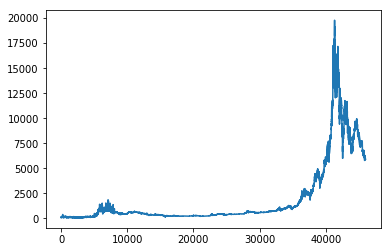

In [3]:
df = df = pd.read_csv(project_path + '/data/raw/data.csv', index_col=0)
# # Kept time because we will know the times at which we want predictions for - no problem with knowing the future.
df = df[['open','high','close','low']]
plt.plot(df['close'])

In [4]:
TRAIN_DATA_START_HOUR_INDEX = 36000
N_FEATURES = len(df.columns)
Tx = 72
Ty = 1

In [5]:
sample = df.iloc[TRAIN_DATA_START_HOUR_INDEX:,:]
sample.shape

(10001, 4)

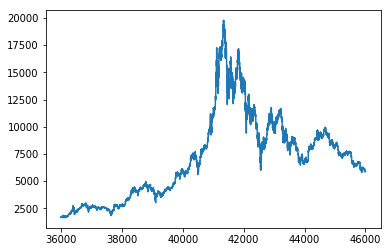

In [6]:
plt.plot(sample['close'])

In [7]:
X = series_to_supervised(data=sample, n_in=Tx, n_out=Ty)
Y = series_to_supervised(data=list(sample['close']), n_in=Tx, n_out=Ty)

In [8]:
"""
Train dev split. (80/20) rule is kind of over. Taking the dev set from the end of the data set because 
that data is closest in distribution to our current testing scenario (getting real time predictions). Note: I call
the dev set the 'test' set in the variable names, but it's really a dev set.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)
"""
Now trim the feature values from the outcome matrix and the outcome values from the feature matrix
"""
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-Ty:]
Y_test = Y_test.iloc[:,-Ty:]
X_train = X_train.iloc[:,:-(Ty*N_FEATURES)]
X_test = X_test.iloc[:,:-(Ty*N_FEATURES)]


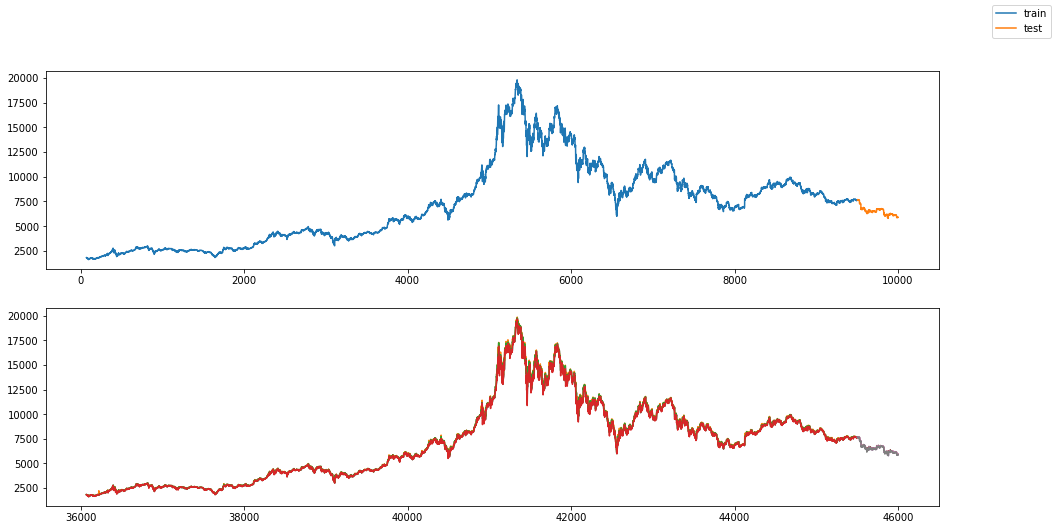

In [9]:
fig, ax = plt.subplots(2)
fig.set_size_inches(16,8)
ax[0].plot(Y_train, label='train')
ax[0].plot(Y_test, label='test')

ax[1].plot(X_train.iloc[:,-N_FEATURES:])
ax[1].plot(X_test.iloc[:,-N_FEATURES:])
fig.legend()

In [10]:
"""
Scale the data for the RNN. Very important otherwise convergence would take a milenia.
"""
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_scaling=True, with_centering=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# pd.DataFrame(X_train_scaled)

# X_test_scaled = X_test.as_matrix()
# X_train_scaled = X_train.as_matrix()

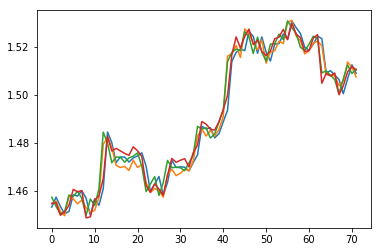

In [12]:
"""
Have to reshape the model into a 3D array to fit the RNN Model.
"""
def shape_model_data(data, Tx, n_features):
    model_data = data.reshape((data.shape[0], Tx, n_features))
    return model_data
X_train_3D = shape_model_data(X_train_scaled, Tx, N_FEATURES)
X_test_3D = shape_model_data(X_test_scaled, Tx, N_FEATURES)

plt.plot(X_train_3D[9000,:,:])

In [19]:
# from sklearn.preprocessing import Normalizer
# norm = Normalizer(norm=)
# Y_train_norm = norm.fit_transform(Y_train)
# Y_test_norm = norm.transform(Y_test)

In [13]:
from keras.layers import BatchNormalization, Conv1D, TimeDistributed, ZeroPadding1D, Activation


from keras.initializers import RandomNormal

def lstm_model(input_shape, num_outputs):
    model = Sequential()
    
#     initializer = RandomNormal(mean=1.0, stddev=0.05, seed=0)
    
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=False))
    
#     model.add(Dropout(0.1))
    
#     model.add(LSTM(64))
    
#     model.add(Dropout(0.1))
    
    model.add(Dense(1))
    
    model.add(Activation('linear'))
      
    return model

In [14]:
rnn_model = lstm_model(X_train_3D.shape[1:], Ty)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [15]:


N_EPOCHS = 5
BATCH_SIZE = 128

"""
Compile and fit model.
"""
alphas = [0.03, 0.01]

for alpha in alphas:
    rnn_model.compile(loss='mae', optimizer=Adam(lr=alpha))

    fit = rnn_model.fit(X_train_3D, Y_train,
                        epochs=N_EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_3D, Y_test))




Train on 9432 samples, validate on 497 samples
Epoch 1/5
9432/9432 [==============================] - 6s 642us/step - loss: 7071.1888 - val_loss: 6386.6071
Epoch 2/5
9432/9432 [==============================] - 6s 584us/step - loss: 6950.9080 - val_loss: 6267.6599
Epoch 3/5
9432/9432 [==============================] - 5s 572us/step - loss: 6832.4302 - val_loss: 6149.4972
Epoch 4/5
9432/9432 [==============================] - 5s 578us/step - loss: 6714.4602 - val_loss: 6031.6873
Epoch 5/5
9432/9432 [==============================] - 5s 580us/step - loss: 6596.7292 - val_loss: 5914.0385
Train on 9432 samples, validate on 497 samples
Epoch 1/5
9432/9432 [==============================] - 7s 729us/step - loss: 6517.6745 - val_loss: 5874.9364
Epoch 2/5
9432/9432 [==============================] - 6s 630us/step - loss: 6478.5711 - val_loss: 5835.8563
Epoch 3/5
9432/9432 [==============================] - 5s 541us/step - loss: 6439.5111 - val_loss: 5796.7952
Epoch 4/5
9432/9432 [=============

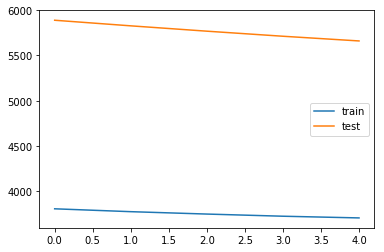

In [26]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.legend()

In [16]:
prediction = rnn_model.predict(X_test_3D)

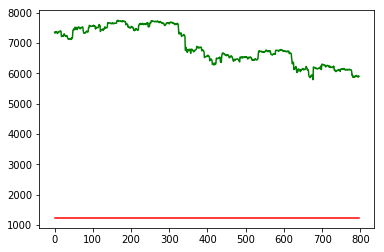

In [17]:
import matplotlib.pyplot as plt
plt.plot(prediction, 'r')
plt.plot(Y_test.values, 'g')